# Brief Introduction to Hyperspectral Classification 

The goal of hyperspectral classification is to classify each pixel/data point into one of $K$ classes.  In general, classification methods are more effective at classification than hyperspectral unmixing. However, classification approaches are not effective at determining sub-pixel proportion amounts or how much of a material can be found within the field of view corresponding to a pixel.  

In general, hyperspectral classification approaches involve:
1. (optionally) feature extraction 
2. application of a standard classifier (i.e., classifiers from the machine learning literature).  

Many approaches have been investigated for the optional feature extraction step.  These include features that combine spatial and spectral characteristics: 
* M. Dalla Mura, A. Villa, J. A. Benediktsson, J. Chanussot and L. Bruzzone, "Classification of Hyperspectral Images by Using Extended Morphological Attribute Profiles and Independent Component Analysis," in IEEE Geoscience and Remote Sensing Letters, vol. 8, no. 3, pp. 542-546, May 2011. <url>http://ieeexplore.ieee.org/document/5664759/</url>
* Z. Zhong et al., "Discriminant Tensor Spectral–Spatial Feature Extraction for Hyperspectral Image Classification," in IEEE Geoscience and Remote Sensing Letters, vol. 12, no. 5, pp. 1028-1032, May 2015. <url>http://ieeexplore.ieee.org/document/6985594/</url>
* S. Jia, J. Hu, J. Zhu, X. Jia and Q. Li, "Three-Dimensional Local Binary Patterns for Hyperspectral Imagery Classification," in IEEE Transactions on Geoscience and Remote Sensing, vol. 55, no. 4, pp. 2399-2413, April 2017. <url>http://ieeexplore.ieee.org/document/7831381/</url>
* among many others..

When feature extraction is not applied, the hyperspectral signatures are used as inputs to the classifier directly. 

A large variety of classifiers have been applied to hyperspectral imagery including Support Vector Machines, Neural Networks/Deep Learning, Dictionary Learning-based approaches, among others. 
<ul>
<li> J. Li, X. Zhao, Y. Li, Q. Du, B. Xi and J. Hu, "Classification of Hyperspectral Imagery Using a New Fully Convolutional Neural Network," in IEEE Geoscience and Remote Sensing Letters, vol. 15, no. 2, pp. 292-296, Feb. 2018. <url>http://ieeexplore.ieee.org/document/8249752/</url>
<li> W. Liu, J. E. Fowler and C. Zhao, "Spatial Logistic Regression for Support-Vector Classification of Hyperspectral Imagery," in IEEE Geoscience and Remote Sensing Letters, vol. 14, no. 3, pp. 439-443, March 2017. <url>http://ieeexplore.ieee.org/document/7837659/</url> 
<li> X. Sun, N. M. Nasrabadi and T. D. Tran, "Task-Driven Dictionary Learning for Hyperspectral Image Classification With Structured Sparsity Constraints," in IEEE Transactions on Geoscience and Remote Sensing, vol. 53, no. 8, pp. 4457-4471, Aug. 2015. <url>http://ieeexplore.ieee.org/document/7053943/</url>
</ul>

All references above are simply a mostly, random selection of these methods.  Many, many more options appear in the literature. 


In [1]:
# imports and setup
import numpy as np
import os.path
import scipy.io
from loadmat import loadmat

import matplotlib as mpl
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*1.5
import matplotlib.pyplot as plt

In [2]:
# load gulfport campus image (with labels)
img_fname = 'muufl_gulfport_campus_1_hsi_220_label.mat'

dataset = loadmat(img_fname)['hsi']

hsi = dataset['Data']
n_r,n_c,n_b = hsi.shape
wvl = dataset['info']['wavelength']
rgb = dataset['RGB']

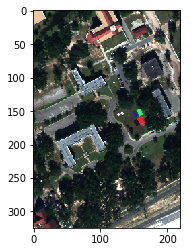

In [3]:
# plot the RGB image to see what we are looking at
plt.imshow(rgb)

In [4]:
# pull label info from the dataset
gt = dataset['sceneLabels']
label_names = gt['Materials_Type']
label_img = gt['labels']

In [5]:
# inspect the label values
print('min label value:',label_img.min())
print('max label value:',label_img.max())
print('label names:',label_names)

min label value: -1
max label value: 11
label names: ['trees' 'grass_pure' 'grass_groundsurface' 'dirt_and_sand'
 'road_materials' 'water' 'shadow_building' 'buildings' 'sidewalk'
 'yellowcurb' 'cloth_panels']


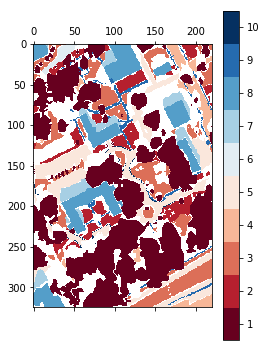

In [6]:
# show the labels as an image
def discrete_matshow(data,minv=None,maxv=None,lbls=None):
    #https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
    #get discrete colormap
    if minv is None:
        minv = np.min(data)
    if maxv is None:
        maxv = np.max(data)
    cmap = plt.get_cmap('RdBu', maxv-minv+1)
    # set limits .5 outside true range
    newdata = data.copy().astype(float)
    newdata[data > maxv] = np.nan
    newdata[data < minv] = np.nan
    mat = plt.matshow(newdata,cmap=cmap,vmin = minv-.5, vmax = maxv+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(minv,maxv+1))
    
discrete_matshow(label_img,1,10)

In [7]:
# train a nearest neighbor classifier with N samples from each of 10 classes (1-10)
from sklearn.neighbors import KNeighborsClassifier

# construct the training set
samples = []
labels = []
n_samp_per = 100
for i in range(1,11):
    lbl_inds = (label_img == i).nonzero()
    n_inds = lbl_inds[0].shape[0]
    ns = min(n_inds,n_samp_per)
    perm = np.random.permutation(np.arange(n_inds))
    perm_lbl = (lbl_inds[0][perm],lbl_inds[1][perm])
    pix = hsi[perm_lbl[0][:ns],perm_lbl[1][:ns],:]
    lbls = np.full((ns,1),i,dtype=int)
    samples.append(pix)
    labels.append(lbls)
    
X = np.vstack(samples)
y = np.vstack(labels).squeeze()

In [8]:
# fit the KNN classifer
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [9]:
# predict outputs
M = np.reshape(hsi,(n_r*n_c,n_b))
Z = knn.predict(M)

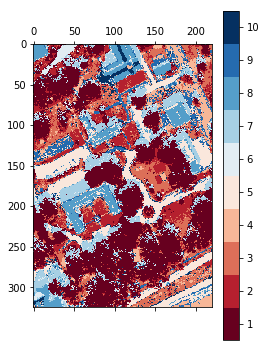

In [10]:
# reshape back into an image and dispay results
z_img = np.reshape(Z,(n_r,n_c))
discrete_matshow(z_img)

['trees' 'grass_pure' 'grass_groundsurface' 'dirt_and_sand'
 'road_materials' 'water' 'shadow_building' 'buildings' 'sidewalk'
 'yellowcurb' 'cloth_panels']


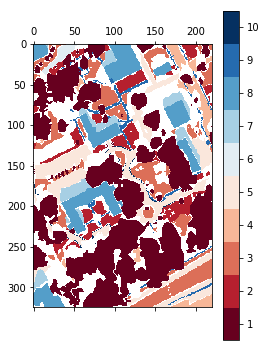

In [11]:
# show the training data again for comparison
print(label_names)
discrete_matshow(label_img,1,10)

In [12]:
# evaluate performance on training set using confusion matrix, accuracy score
from sklearn.metrics import confusion_matrix

lbl_array = np.reshape(label_img,(n_r*n_c))
valid_inds = np.logical_and(lbl_array > 0,lbl_array < 11)

cm = confusion_matrix(lbl_array[valid_inds],Z[valid_inds])
row_sum = cm.sum(axis=1).reshape((cm.shape[0],1)) #sum of rows as column vector
norm_cm = cm/row_sum

overall accuracy: 0.775


Text(0.5, 1.0, 'Per-class confusion')

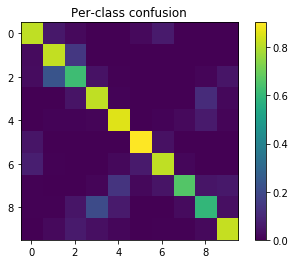

In [13]:
# compute overall accuracy, 
oa = np.diag(cm).sum()/cm.sum()
print('overall accuracy: %.3f'%oa)
plt.imshow(norm_cm)
plt.colorbar()
plt.title('Per-class confusion')